# Introduction to Deep Learning

Please, make a copy of this colaboratory in order to be able to make changes **(File -> Save a copy in Drive)**.


# Convolutional Neural Networks

## Keras on CIFAR10


In this part of the class, we will examine convolutional neural networks (CNN). As CNNs were designed specifically to work with imaging data, we will use CIFAR-10 dataset to demonstrate their effectiveness on images. The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60 000 pictures divided into 10 classes (hence the name CIFAR-10). Classes include common objects such as airplanes, automobiles, birds, cats and so on. Our goal is to train a convolutional neural network to classify these images.

The following instructions help to install required dependencies and load the data.


In [1]:
# A bit of setup again
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR10
from tensorflow.keras.datasets import cifar10

# Keras comes with built-in loaders for common datasets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# shorten dataset for quicker training
X_train = X_train[:25000]
y_train = y_train[:25000]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (25000, 32, 32, 3)
Train labels shape:  (25000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


Let's visualise several random images from each class to get familiar with the data:


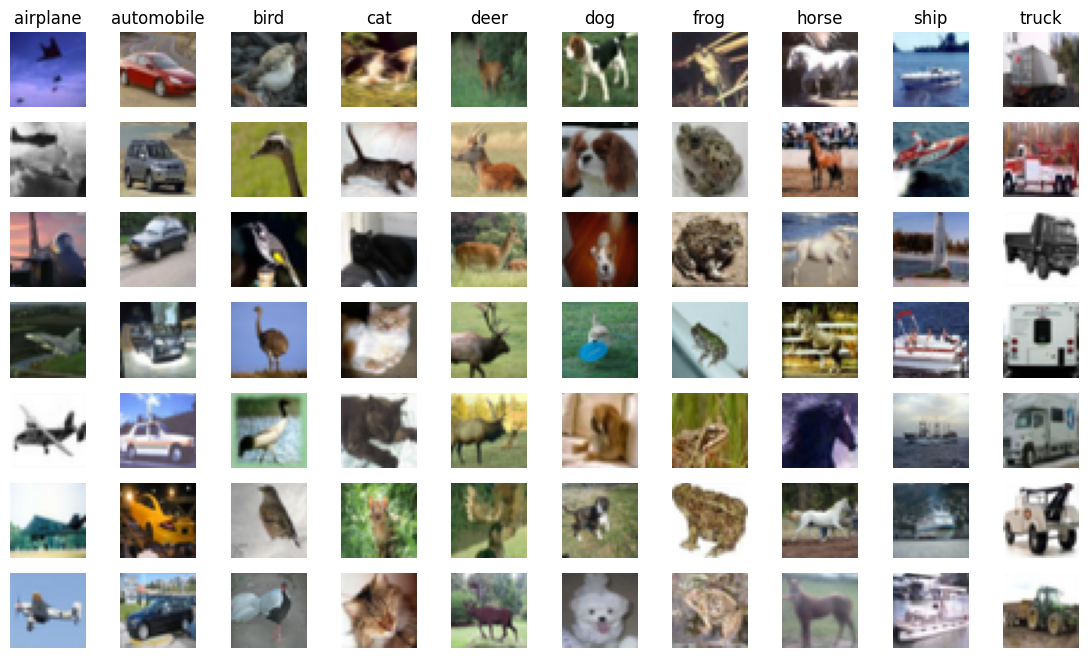

In [2]:
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
# "Names" of classes:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
num_classes = len(class_names)

samples_per_class = 7 # Number of images from each class we want to see
for y, cls in enumerate(class_names):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((32, 32, 3)), plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<font color=purple size=4>**Question**: Do all images look right? Is there anything unexpected?
</font>


Building an effective neural network model requires careful consideration of the network architecture as well as the input data format.

<font color=purple size=4>**Question**: What do the 4 dimensions ((25000, 32, 32, 3)) of X_train represent?
</font>


**Data normalisation step.** Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation [[source](https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258)]. In our case we do it for each RGB component separately.


In [3]:
mu = X_train.mean(axis=(0,1,2)) # finds mean of R, G and B separately
std = X_train.std(axis=(0,1,2)) # same for std
X_train_norm = (X_train - mu)/std
X_test_norm = (X_test - mu)/std

In [4]:
mu

array([125.49860625, 123.01119887, 113.80192262])

Now we are ready to define our Convolutional Neural Network model. First we need to specify the layers that we will be using.

Here is the architecture that we shall use:

1. 3x3 **convolution** with 32 **filters**, **stride** 1, **padding** `same`
2. **batch normalization**
3. **relu** activation
4. 3x3 **convolution** with 32 **filters**, **stride** 1, **padding** `valid`
5. batch normalization
6. relu
7. **max pooling** 2x2
8. **dropout** 0.25
9. **flatten**
10. **dense** 100
11. batch normalization
12. relu
13. dropout 0.5
14. dense 10
15. **softmax**

<font color=purple size=4>**Question**: Which of the above layers you are familiar with? Which are new?
</font>

You can consult Keras documentation for layer parameters:

-   [Convolutional layers](https://keras.io/layers/convolutional/)
-   [Pooling layers](https://keras.io/layers/pooling/)
-   [Normalization layers](https://keras.io/layers/normalization/)


Here is how aforementioned architecture can be implemented in Keras. Note the difference in notation with network we defined at the end of the previous practice session. Here we explicitely specify input and output of each layer instead of chaining them one after another.


In [5]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

x = Input(shape=(32, 32, 3))
c1 = Conv2D(32, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
c2 = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
p2 = MaxPooling2D(pool_size=2)(a2)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector
h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)
z = Dense(10)(d3)
p = Activation('softmax')(z)

<font color=purple size=4>**Question**: What might be a benefit of using **functional** model definition compared to **sequential** we used before?
</font>


Now that we have defined the arhitecture, we can create a model simply by saying what is the input and what is output. Cross-entropy loss is applied to the network with Adam optimizer and additional accuracy metric.
**`sparse_categorical_crossentropy`** loss allows us to pass integer class values directly as targets and is potentially more efficient than categorical_crossentropy, which needs one-hot vectors as targets.

`model.summary()` prints out layer list with output shapes and is very useful for debugging the model.


In [ ]:
# conv2d
32 * 3 * 3 * 3 + 32

# +32 is for the biases
# 3 * 3 * 3 is for the weights (height, width, input channels)
# 32 is the number of filters

896

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       720,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 731,910 (2.79 MB)

 Trainable params: 731,582 (2.79 MB)

 Non-trainable params: 328 (1.28 KB)

<font color=purple size=4>**Question**: Do you think you can figure out where for example value **896** learnable parameters is coming from? What about **9,248** or **1,010**?
</font>


Let's train this convolutional neural network on CIFAR10, `validation_split` defines the number of data rows that will be used for validation.


In [7]:
352*64

22528

In [ ]:
# usually we dont add epochs as a parameter, we set limits, such that if after 5 training epochs the validation loss does not decrease, we stop training

In [ ]:
# First Epoch always takes longer time because of graph initialization

In [8]:
# Fit the model; returns History object
history = model.fit(X_train_norm, y_train, batch_size=64, epochs=20, validation_split=0.1)

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.4205 - loss: 1.6628 - val_accuracy: 0.5544 - val_loss: 1.2801
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.5497 - loss: 1.2778 - val_accuracy: 0.6172 - val_loss: 1.0929
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6018 - loss: 1.1268 - val_accuracy: 0.6308 - val_loss: 1.0615
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.6393 - loss: 1.0227 - val_accuracy: 0.6516 - val_loss: 0.9877
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.6644 - loss: 0.9554 - val_accuracy: 0.6492 - val_loss: 1.0081
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.6787 - loss: 0.9015 - val_accuracy: 0.6352 - val_loss: 1.0390
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.7024 - loss: 0.8403 - val_accuracy: 0.6556 - val_loss: 0.9927
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.7156 - loss: 0.8067 - 

<font color=purple size=4>**Question**: What do concepts such as **step**, **batch** and **epoch** stand for?
</font>


<font color=purple size=4>**Question**: Did you notice that the first epoch is taking more time? Why do you think it is so?
</font>


The following graphs illustrate the behaviour of Loss and Accuracy during the training process.


Text(0.5, 1.0, 'Accuracy')

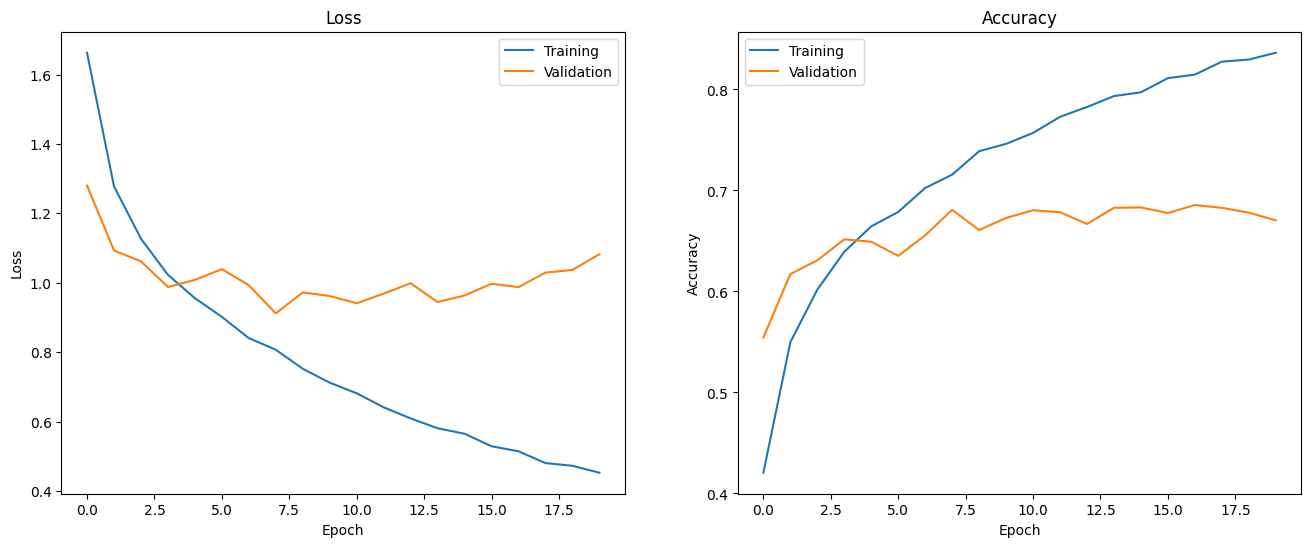

In [9]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [ ]:
# Loss is calculated on probabilities - for example, if you (mis)classify a dog image as a frog with 80% confidence on Epoch N and on Epoch N+1 you (mis)classify a dog image as a frog with 95% confidence then loss increases but accuracy does not change.

<font color=purple size=4>**Question**: What do these curves show?
</font>


Next we will evaluate our trained network on the test and training data.


In [10]:
# IPython notebook just prints out the returned values - loss and accuracy
model.evaluate(X_test_norm, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6667 - loss: 1.0505


[1.0504783391952515, 0.666700005531311]

In [11]:
# the same for training set
model.evaluate(X_train_norm, y_train)

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9270 - loss: 0.2773


[0.27728626132011414, 0.9270399808883667]

<font color=purple size=4>**Question**: Based on the training and test accuracy, did training go well?
</font>


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


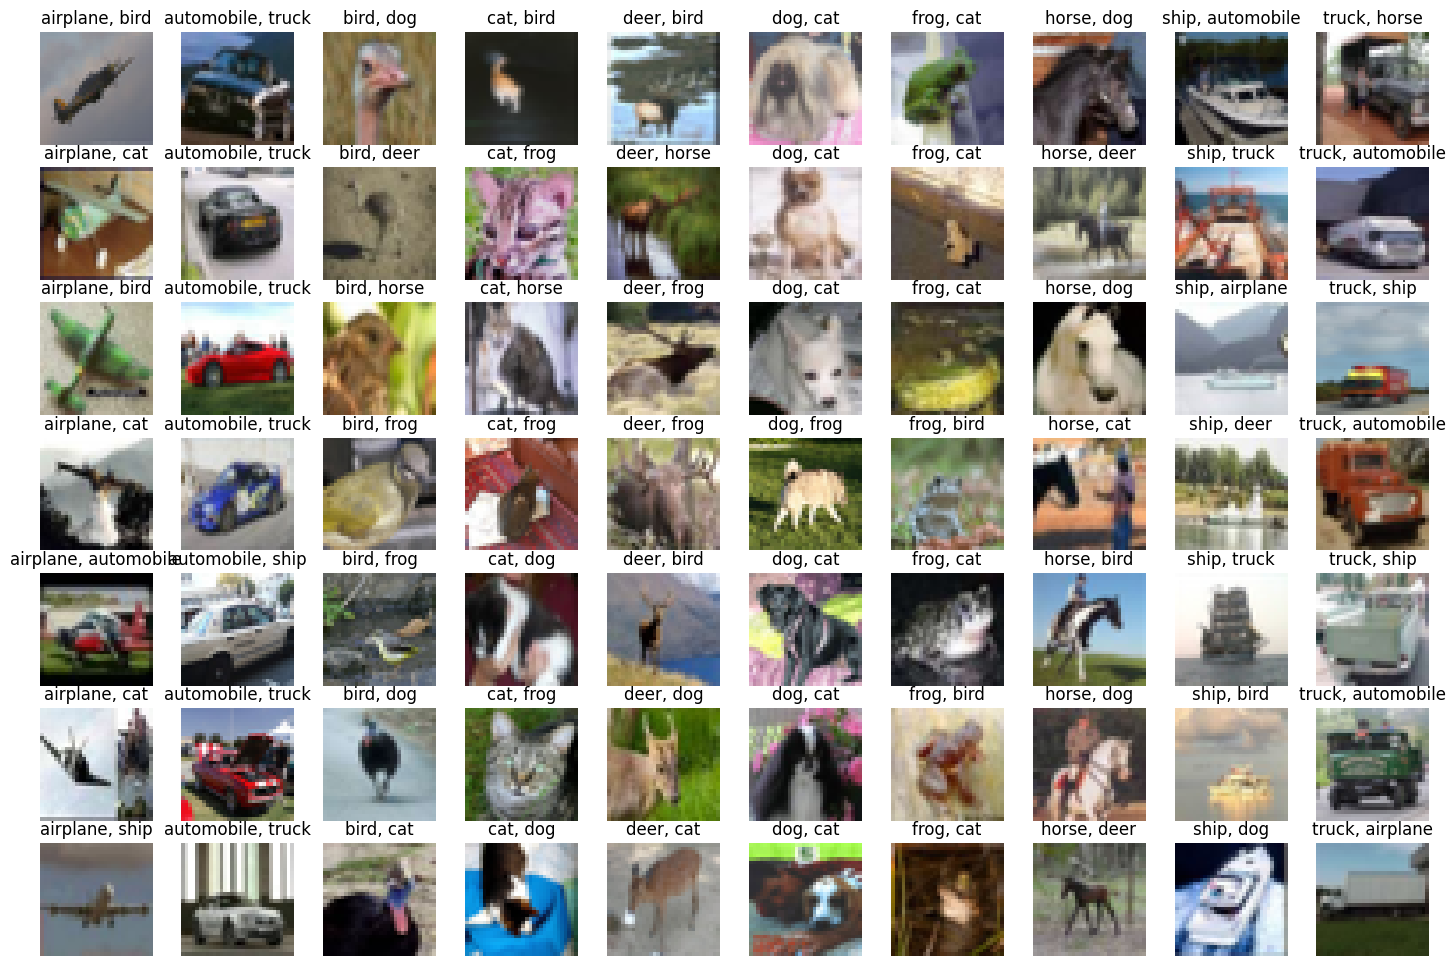

In [12]:
test_predicted = np.argmax(model.predict(X_test_norm), axis=1)

plt.rcParams['figure.figsize'] = (18.0, 12.0) # set default size of plots
# "Names" of classes:
classes = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
num_classes = len(classes)
samples_per_class = 7 # Number of images from each class we want to see
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_test == y)

    misclas_idxs = np.flatnonzero(np.array(test_predicted)[idxs] != y)

    if samples_per_class < len(misclas_idxs):
      misclas_idxs = np.random.choice(misclas_idxs, samples_per_class, replace=False)

    for i, idx in enumerate(misclas_idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_test[idxs[idx]].reshape((32, 32, 3)), plt.get_cmap('gray'))
        plt.axis('off')
        plt.title(str(classes[y]) + ", " + str(classes[np.array(test_predicted)[idxs[idx]]]))
plt.show()

## CNN on MNIST

Let's use the same convolutional neural networks we defined above to classify MNIST.


In [13]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"Train images are of shape: {X_train.shape} and labels: {y_train.shape}")
print(f"Test images are of shape: {X_test.shape} and labels: {y_test.shape}")

Train images are of shape: (60000, 28, 28) and labels: (60000,)
Test images are of shape: (10000, 28, 28) and labels: (10000,)


Copy and paste below the CNN architecture we have defined previously.

NB! Make sure the input shape is correct (recall that MNIST is 28x28x1 not 32x32x3 as CIFAR10).


In [ ]:
##### YOUR CODE STARTS #####
x = Input(shape=(28, 28, 1))
c1 = Conv2D(32, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
c2 = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
p2 = MaxPooling2D(pool_size=2)(a2)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector
h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)
z = Dense(10)(d3) # Number of output classes (neuron number)
p = Activation('softmax')(z)
##### YOUR CODE ENDS #####

Compile and train your model, keep the record of loss in the `history` variable.


In [19]:
##### YOUR CODE STARTS #####
model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()
##### YOUR CODE ENDS #####

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       540,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,134 (2.11 MB)

 Trainable params: 551,806 (2.10 MB)

 Non-trainable params: 328 (1.28 KB)

In [21]:
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.1)

Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.9742 - loss: 0.0863 - val_accuracy: 0.9893 - val_loss: 0.0346
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.9795 - loss: 0.0686 - val_accuracy: 0.9880 - val_loss: 0.0424
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.9814 - loss: 0.0601 - val_accuracy: 0.9890 - val_loss: 0.0347
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.9830 - loss: 0.0546 - val_accuracy: 0.9900 - val_loss: 0.0362
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.9854 - loss: 0.0469 - val_accuracy: 0.9887 - val_loss: 0.0382
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.9854 - loss: 0.0449 - val_accuracy: 0.9912 - val_loss: 0.0343
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.9872 - loss: 0.0403 - val_accuracy: 0.9912 - val_loss: 0.0315
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - accuracy: 0.9881 - loss: 0.0375 - 

Visualise the training and validation accuracy and loss dynamics over epochs.


Text(0.5, 1.0, 'Accuracy')

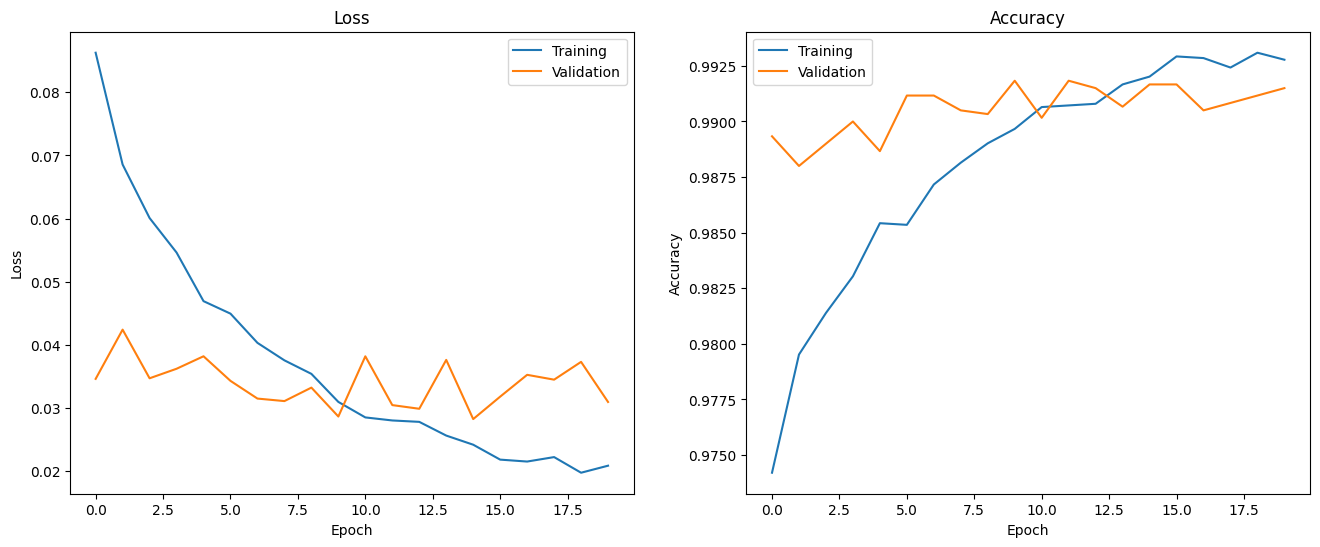

In [22]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

<font color=purple size=4>**Question**: Does our network overfit? Does it have enough power to solve the problem?
</font>


Evaluate model on test images


In [23]:
# IPython notebook just prints out the returned values - loss and accuracy
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9926 - loss: 0.0273


[0.02726808562874794, 0.9926000237464905]

Here we visualise misclassified examples for CNN on MNIST dataset:


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


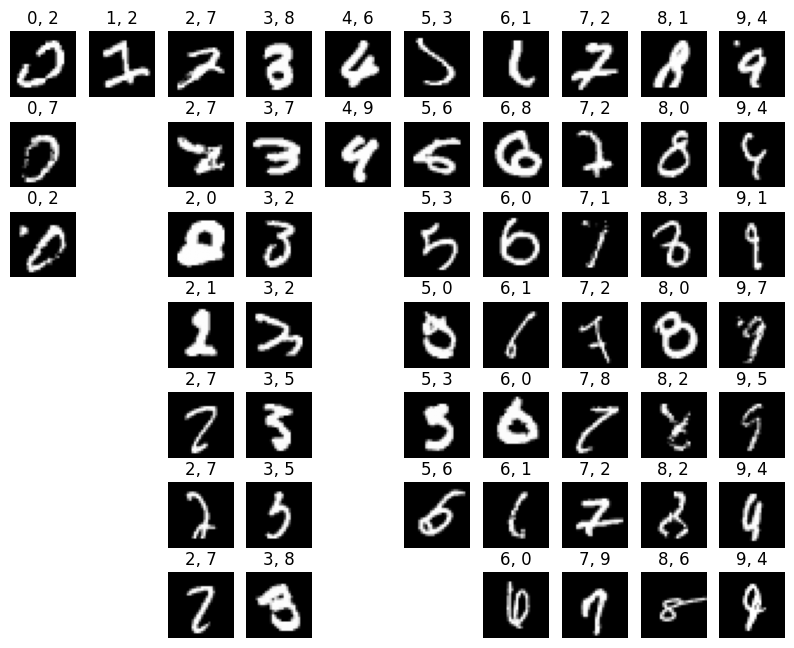

In [24]:
test_predicted = np.argmax(model.predict(X_test), axis=1)

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# "Names" of classes:
classes =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

num_classes = len(classes)
samples_per_class = 7 # Number of images from each class we want to see
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_test == y)

    misclas_idxs = np.flatnonzero(np.array(test_predicted)[idxs] != y)

    if samples_per_class < len(misclas_idxs):
      misclas_idxs = np.random.choice(misclas_idxs, samples_per_class, replace=False)

    for i, idx in enumerate(misclas_idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_test[idxs[idx]].reshape((28, 28)), plt.get_cmap('gray'))
        plt.axis('off')
        plt.title(str(y) + ", " + str(np.array(test_predicted)[idxs[idx]]))
plt.show()

<font color=purple size=4>**Question**: Do misclassifications look reasonable?
</font>


# Fast.ai library

What is [fast.ai](https://docs.fast.ai/)?

Basically fast.ai is Keras on top of Pytorch that uses cutting edge research in Deep Learning.

**Why to introduce yet another library for DL in this class?**

-   want to mention fast.ai online course which is great (it does not require you to use fast.ai library)
-   image scraping exercise in the end of this class
-   fast.ai are usually the first to implement SOTA techniques (e.g. learning rate finder), and thus thier library usually provides cutting edge results in many domains

**Bad things about fast.ai (why my team don't use fast.ai):**

-   if you want to change something or apply fast.ai in a custom way to custom data, the chances are high - it is going to be painful, why? ->
-   the documentation is really bad (and not up-to-date), unless you are Jeremy Howard who has written it


## fast.ai on CIFAR10


In [26]:
!pip install fastai

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.8.0-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached torchvision-0.23.0-cp313-cp313-win_amd64.whl.metadata (6.1 kB)
   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
    --------------------------------------- 0.3/13.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.9 MB 1.2 MB/s eta 0:00:12
   -- ------------------------------------- 0.8/13.9 MB 1.3 MB/s eta 0:00:10
   --- ---------

In [27]:
# Some setup first as usual
from fastai.vision.all import *

from pathlib import Path
from PIL import Image
import requests, io, re
from tqdm import tqdm

# We don't like warnings
import warnings
warnings.filterwarnings('ignore')

from urllib.request import urlopen

In [30]:
path = untar_data(URLs.CIFAR)
dls = ImageDataLoaders.from_folder(
    path,
    train='train',
    valid='test',
    item_tfms=Resize(48)
)

In [ ]:
# resnet34 means 34 (conv) layers

# Resnet is pre-trained model, it means it has its weights calculated from some other similar dataset

In [31]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Saskia/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [01:17<00:00, 1.13MB/s]


In [ ]:
# We train it for 3 Epochs

In [33]:
learn.fit(3)

In [ ]:
# Questions:
#	- What is batch size?

## fast.ai on MNIST


In [ ]:
path = untar_data(URLs.MNIST)
dls = ImageDataLoaders.from_folder(
    path,
    train='training',
    valid='testing',
    item_tfms=Resize(26)
)
learn = cnn_learner(dls, resnet34, metrics=accuracy)

In [ ]:
learn.fit(2)

In [ ]:
!ls /root/.fastai/data/mnist_png/testing/0/

In [ ]:

img = PILImage.create('/root/.fastai/data/mnist_png/testing/0/1692.png')
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

## Creating your own dataset using fast.ai

_by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)_

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).


### Get a list of URLs

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.


### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

In Google Chrome press <kbd>Ctrl</kbd> + <kbd>Shift</kbd>+
<kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd> + <kbd>Opt</kbd> + <kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd> + <kbd>Shift</kbd> + <kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd> + <kbd>Opt</kbd> + <kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls = Array.from(document.querySelectorAll("img"))
	.filter((el) => el.naturalWidth >= 100 && el.naturalHeight >= 100) // Filter by size (at least 200px in width or height)
	.map((el) => el.src || el.getAttribute("data-src"))
	.filter((url) => url && url.includes("gstatic.com") && url.includes("encrypted"))
	.filter((url) => !url.includes("favicon") && !url.includes("logo") && url.startsWith("http"));

window.open("data:text/csv;charset=utf-8," + escape(urls.join("\n")));
```


After both files are downloaded and renamed, upload them to colab by running the following command (or you can just drag-and-drop them into the **Files** tab on the left.)


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!ls

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!ls

In [ ]:
# Unzip data file UNIX

!unzip data.zip -d ./data/

In [81]:
# Unzip data file Windows

!tar -xf "./data.zip"

## Download images

Now you will need to download your images from their respective urls.

The function below will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.


In [34]:
def download_images(csv_path, label='', max_images=10000, timeout=10):
  out_dir = Path('./data') / label

  out_dir.mkdir(parents=True, exist_ok=True)
  df = pd.read_csv(csv_path)

  max_images = min(max_images, len(df))
  df = df.head(max_images)

  for i, row in tqdm(df.iterrows(), total=len(df), desc="Downloading"):
    url = row[0]
    try:
      r = requests.get(url, timeout=timeout)
      r.raise_for_status()
      img = Image.open(io.BytesIO(r.content)).convert("RGB")
      fname = out_dir / f"{i}.jpg"
      if not fname.exists():
          img.save(fname, format="JPEG", quality=90)
    except Exception as e:
          print("Broken url", url, "->", e)

  print(f"\nDataset ready!")


In [ ]:
download_images('jaguar.csv', label='jaguar', max_images=400)

In [39]:
download_images('leopard.csv', label='leopard', max_images=400)

Downloading: 100%|██████████| 400/400 [03:22<00:00,  1.98it/s]


Dataset ready!


In [40]:
classes = ['jaguar','leopard']

Then we can remove any images that can't be opened:


In [41]:
def verify_image(fn: str, min_width: int, min_height: int):
  try:
    im = Image.open(fn)
    im.load()
    width, height = im.size
    if width < min_width or height < min_height:
      return False
    return True
  except Exception as e:
    print(e)
    return False

In [42]:
def verify_images(fns: Path):
    image_files = get_image_files(fns)
    for img_file in image_files:
      if not verify_image(img_file, 100, 100):
        print(f"Corrupted image found and deleted: {img_file}")
        img_file.unlink()

In [43]:
for c in classes:
    print(c)
    verify_images(path/c)

jaguar
leopard


## View data


In [ ]:
# Image net size is 224x224 so we use that Resize 224

In [44]:
dls = ImageDataLoaders.from_folder('data/', valid_pct=0.2, item_tfms=Resize(224))

In [45]:
dls.vocab

['jaguar', 'leopard']

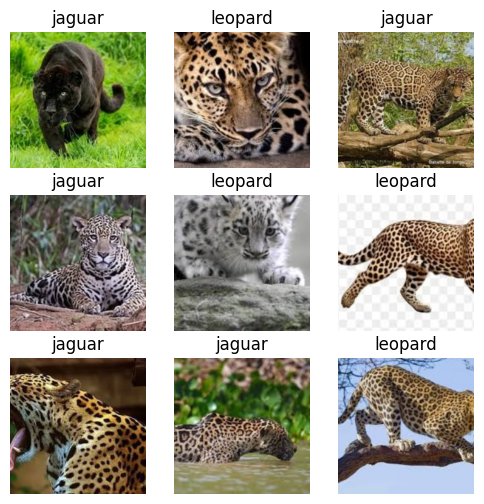

In [50]:
dls.show_batch(max_n=9, figsize=(6,6))

In [47]:
dls.vocab, dls.c, len(dls.train_ds), len(dls.valid_ds)

(['jaguar', 'leopard'], 2, 640, 160)

## Train model


In [51]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

In [52]:
learn.fit(5)

In [53]:
val_loss, acc = learn.validate()
val_loss, acc

(0.7126083970069885, 0.800000011920929)

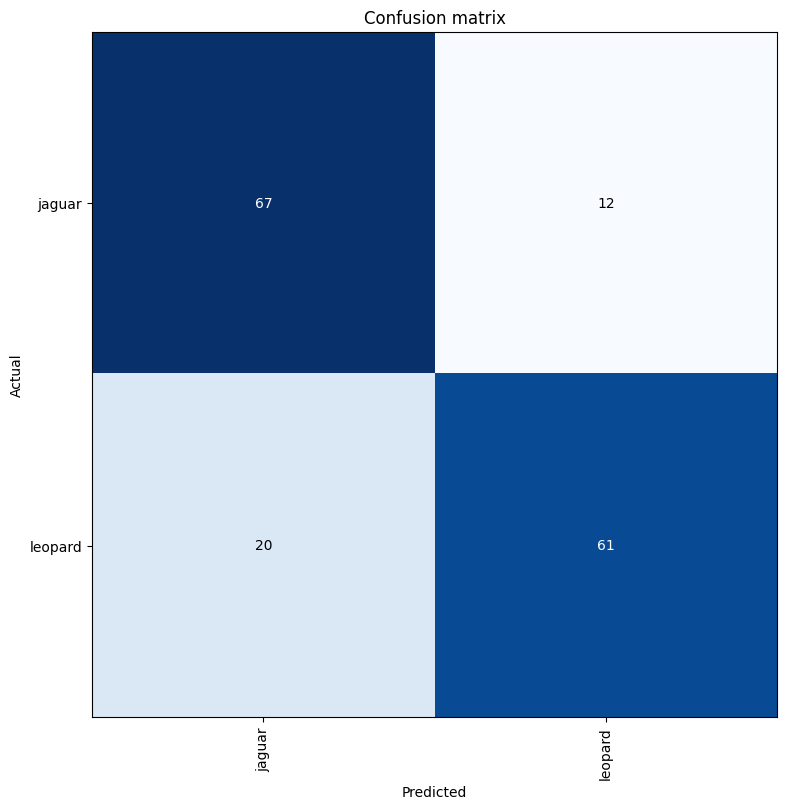

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

# Confusion matrix (x[0], y[1]) and (x[1], y[0]) have true truths (correct classifications) and (x[0], y[0]) and (x[1], y[1]) have false truths (misclassifications)
interp.plot_confusion_matrix()

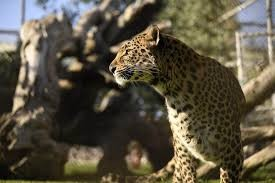

In [55]:
img = Image.open('./data/leopard/14.jpg')
img

In [56]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'leopard'

Get a url on the leopard image from internet and insert it below


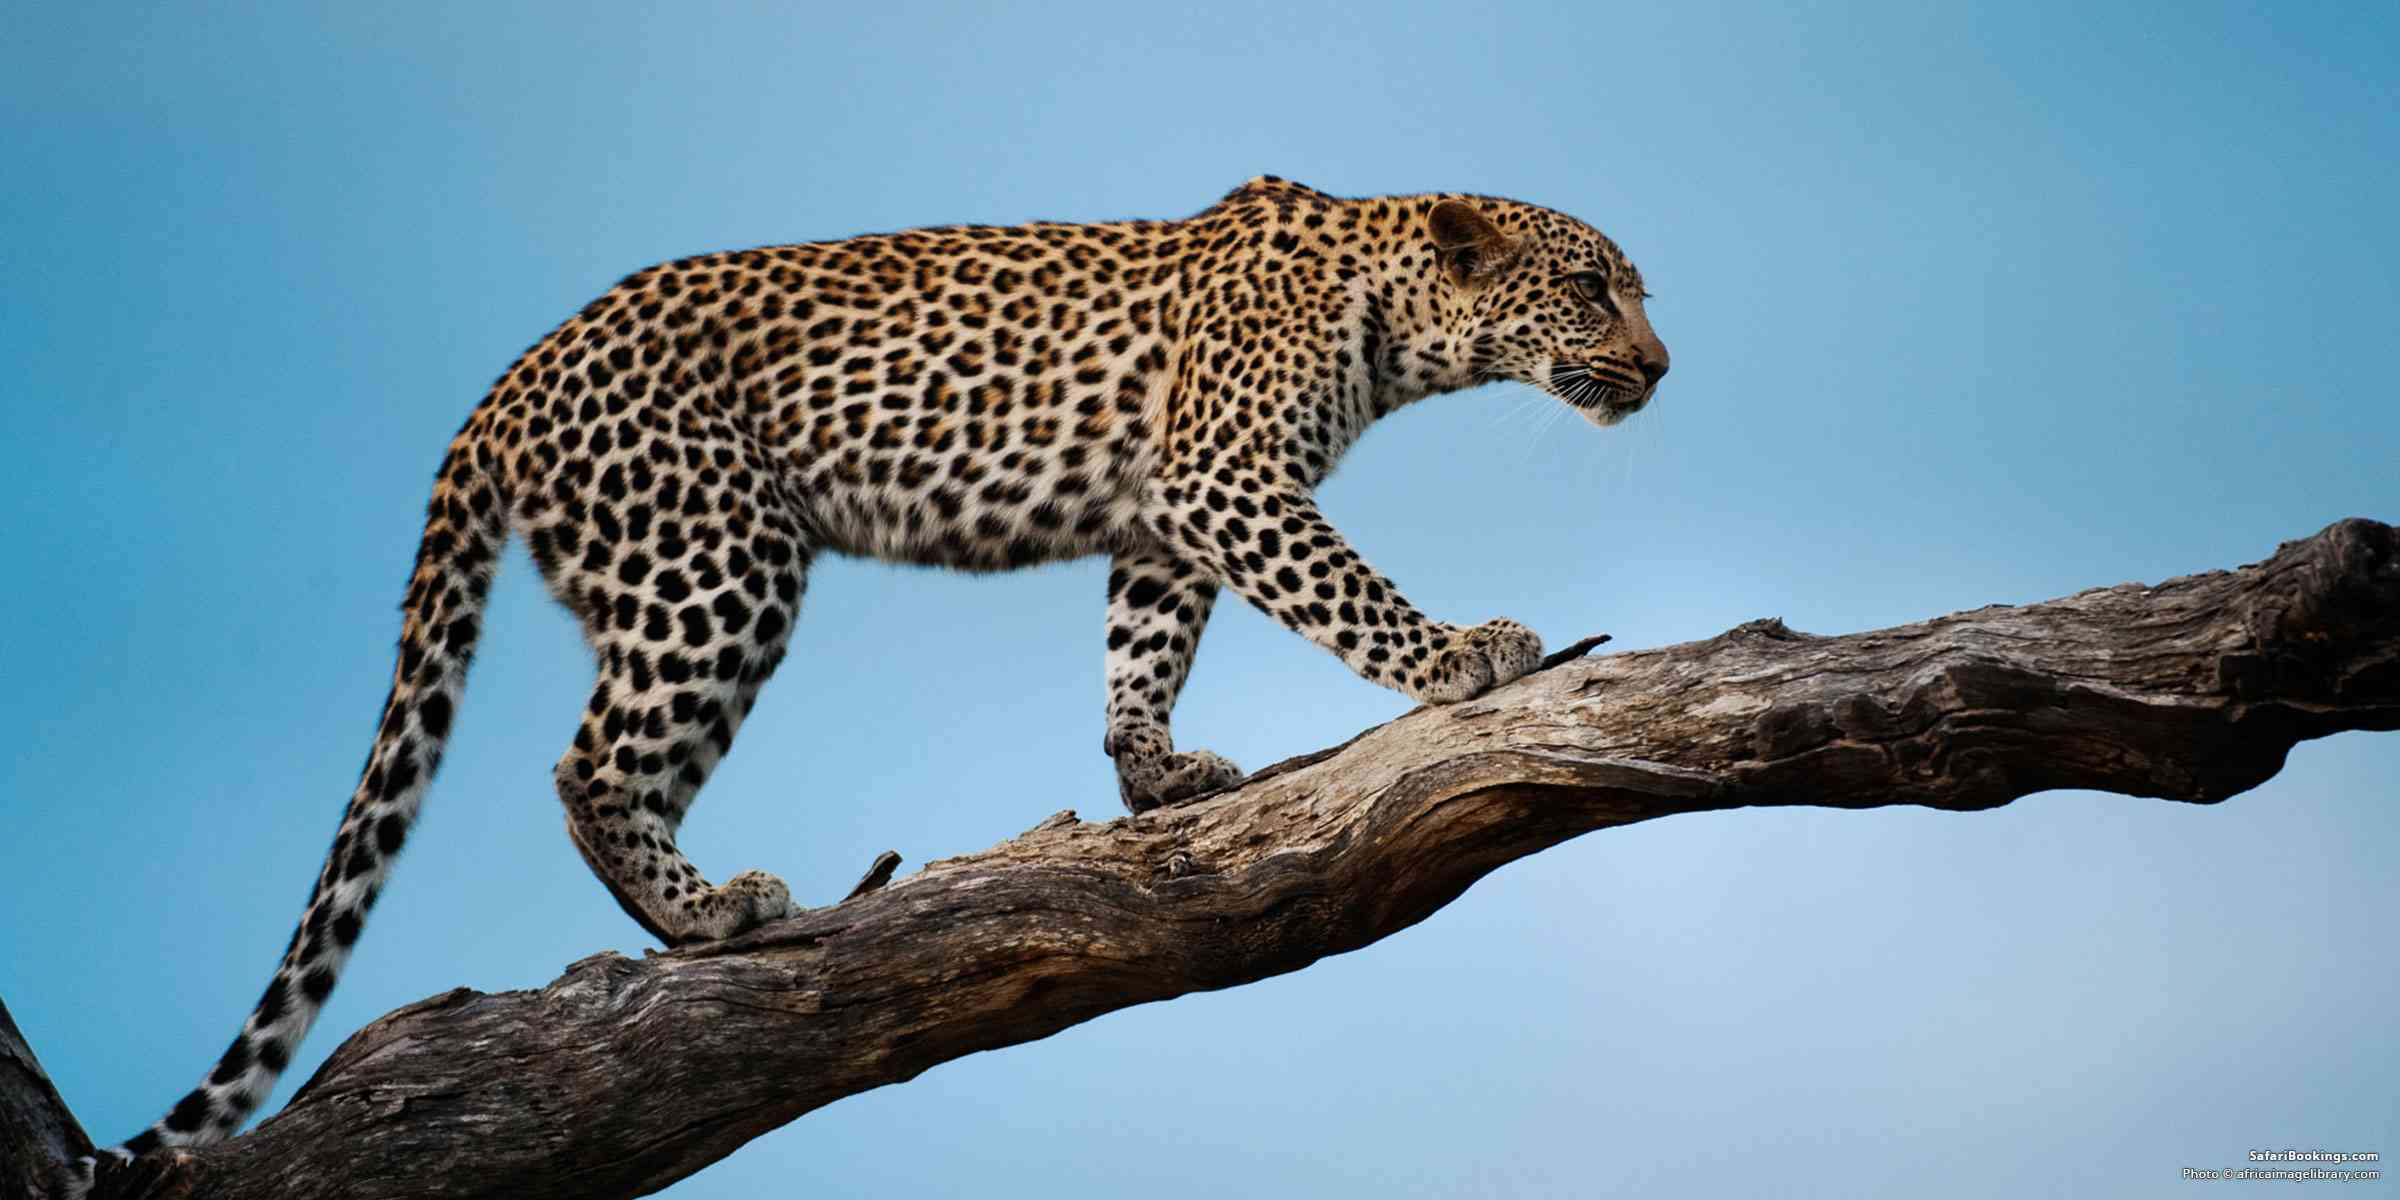

In [63]:
img = Image.open(urlopen("https://cloudfront.safaribookings.com/blog/2022/10/00-5_Fascinating_Facts_About_the_Leopard-BW-header1200px.jpg"))
img

In [64]:
pred_class,pred_idx,outputs = learn.predict(img) # resizes the image automatically
pred_class

'leopard'

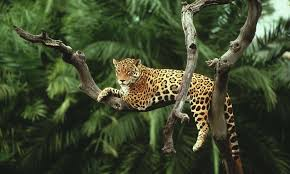

In [67]:
# Jaguar
img = Image.open(urlopen('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxITEhUTEhMWFhUXFxgYFRgYGBcXGBYYFxcXFxcYGBgYHSggGB0lHRUXITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGy0lHyUtLS0vLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAK4BIgMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAEBQIDBgEAB//EAD4QAAIBAgQDBgMGBQMDBQAAAAECEQADBBIhMQVBUQYTImFxgTKRoRQjscHR8AdCUmLhcqLxFjOCFRckU5L/xAAZAQADAQEBAAAAAAAAAAAAAAABAgMABAX/xAAoEQACAgICAgEDBAMAAAAAAAAAAQIRITEDEkFRIhNh8CNCgbEEMnH/2gAMAwEAAhEDEQA/APn1zA5pK7LoPM86M4fYk5GMkb6be9FWsDcAAGjGYPQ9aPw9ghAM2p3Mc/OuGU3VEGwC/wAPiCokmq1w86Ebb+tMFADaNPUelMbmGRkRojNOaOoNSti2LeH4EIjFQCW+QofAAteCxz9qZ4pHTyEQIqjhbC25uMJgaUL9msv7U4gEhJ+GKRuhIEa1DieL725PLXWl9niRUkRPSrRg6wOkaHAuUAMTTqzi1JDA6jcGkfCsWzQCpk1oMPhEzAsBU5YYj2LeIYTPLo0E/Ep50tW2uUhp9J0p/wAUtqp0bKOVZ65YJYySQaKZkKb+EAOp05BaFtkg+ER0nenuJtqi/ASZ0M7UpxN+elXi2x0ysXDs9FYeEuK42HOhltncwPWvWsUQ3JhMmi86Cbbgt85brHdl58hypSeIG2CdZbQHoPKrcNiT3DG2Jd9x0pVibpcIp0j9dfwqaQlBmM4mTctW1mAB6knrWkt31DC0BmUKe8nZZrDWMYqXGc282kJBiD1o7CY2EdSTJHiPMk/lRlGkZxCHshbsAeEnT0NJsRaAusp66VosJ4lCPoRGQ8jSni1shwcus6xz860WFDXDpnFu2LYuM3hCkldToDI6Va/ZZ2CXbrJhwTlCIGuFhrqANc2jSNdFLHoSuyRY4i2UjNIALTC5iEZgOZCuYXSTpNabjfAmdFul7mcZriOmZcqrBVW8WrEKTMHUwdAASisKrIvwHDrdm3owVTDeMS+g+IIJLbjVgoUcgayHaXji3GyWHuATq5+K4OsA6CRMkgmucR4tdz3EVQACyvPw7kEIogaSRrO25pGDHI/rTpJDOVaJJm5m4QJjx5NesAN+NdHC3JBDKAdp1PuQoBqVsjmvzNFrfLEJlkbD8prOTJubPYngvcrn74OdNlhRJ1EkmfaqOMXluBTbtrbIHiVPh9Rz9ZppxXHzaNu8CtxAAqx4XU7HyYUk4XbZnUDc6Ly15Uc7Am3svwJZgAdc2/tzP4UO2E1IA3E0xebYiNdR6a0Q1kC5HQQPSgnkpDyB8CdXK27xOQTlgSwidBW97M4q1aujImkbvAM1jezNi22I+8kIudtBJJ2A+darFcIYuDZV8p2nShN5J8mz67w27nQNpqOW1EuNDFI+yvD3s2QHcmdfSngYHaqLRJCG7wtSxP2YHU6yuv1rtNWxSjnXqn0XsNo+D2MXA1XWQR0ijME2ZrisY1lfQVZatplgieZ8hSy5aYkmyWBEGYBMdCDv6Vy1bMshpw2Uuf7Tr5zXMDjAbbIT6Ghzi2uoY8LeYjMZj/x/DzoMYdlUAg6kzNN0rYZQa2HnEaamY51RduKVIYgSapxLroF9WP4ULdxNvaZPMER8utZRsyQJjLsGFHhiPeqsJaTOJA2+tcxWcyxMLyivcNQO28AfM1aqiMavDXlRCcok7dapXEM2+YDmTUra6GACANC29AvxPLKkCZrnjHIg0XEBtIBjrUMU6zqP/wA0uuYvQxA8wKBv4gBYMkHY86okGieJxJL5D7TpXCw5AT13ig714Rofc7+lU2b+s1RRwGgy5hgxkmZ613D4ZcxBIE6D1qixcLNHKZq5LQYnl+dbPkwz7N3RauE3Ntjz+VGdpDbxN3Nh1yKiZSPOlN7HAqFyjTpzr1i9GoMTy60L8grNkLWDAaOnWq8XY5rqavxGJjcfKhrxBhlME0FbeQldnGssB5yzoeYNaK4q3RmkZoEHrWfS65lWGcDyrtjFFfhBEax5UzVho2nYMhMcmcEQGMGN1GeZPkpNfSgVayEY6MCo5awQGBHOI0r47wTjiriLNy5oFYZj/Y3hb/axr6Lw1rjWLnfKQ1slFVd8qmQfKfFA8hWiPFYPlHG7ZW5dWNncdNmPKkTXjW7/AIgWxav5hBFz4v8AWsT81ZD7msU6hiSIFND7mI4O2SedarhIC2hbIEXDJ2lsp2DfymlfAeDXL0kMAo+IztRXGLFu393buljuZ1E+RFFsSWXRT2puqXUKcygQJHiXX4SecUBhUAUyYG/pG1ctoZ8R0rl9ROsD1rfYK9B3BUNy9IaQoLv/AKV1g+pge9S4jcysepA/Cfz+lNhh7eHsZVMs8Z20EwJyj+3X6n2y+IvFmjc7D3rItFUj6t/DzsuowyXXBDuBcGm6nVPaIPvX0AlQAMsHlpRVjChbaoBAVAo8gFAA+lI14or2becwzXAg9Q0fkaZrJySbbyDca4+1qzcLJEZgD6Vh+E9u7lm2c5zbtP4V3+JPGSbRsodO8uBzzMvAA+RrM9ocAWtI9saOAYHJVECfUzS09hjH2Et28uEkkmvVn04YsCZmNa9TlKiP0xkmP6qKwd1g+sa6SOdLFEAnSY3oXD3WV4J0ma5EidDTjHD7gIuWBO5dQxDT1X66VRY41nUI8ZhoQ8A+c7EHlv60zTHalWOn11pZxLAK8Fj3g15eIdBO+lPGXhlI8nhkbt3DjVluGQCQrDfXTVNR7+9JruMtviAcpS3ly5TyhSBvudd/OrMJwu2xC5mzawCY29qklruLsXFd7fRSudSRuuYR7fpVE4rRROPgFxFtkUtuJIVl8SR6jQHyMGhsPiGAlTA2kVsOG9o8EhJJv2mJBIKAgwdPgO+p36ddxMbxPDXn7rvmayQYYo2dWnQgXsxXYaKwB11FFf8ADOBbw3BE2sxvTPLrQOJskHUfI0ZguAYm2jXFi7YQmXtsrDL/AFFJzp5yNPTWqLt1ROgM86k1TItUwS24jUUHjTz36HpRDyxyrRI4ON7jeworGTIQluteBrSJgUGmQTynpRWH4WjHLlEHn5c6b6iD2RmeWm43ojC3JMe1NMVwtJOUeVALg8utbsmbAKyQ0HrVpYiGqWKsmQaneQGzI+IGtsxG7elKow2KCgzvyqKr90T1NChZpoxQUi9cWdYMVNHzazr5UD611FPI03VDUM2Rq+v9l75fDvccnW3bUjkxNoFmYcz0/wA18cs3GiDX0Ps/x5MPgXvXAYXKgHN3IyqIGwlDqeQpEaIk7e23dmbdZGXSJ8IzNoYMkxp/SNawzA1u04+caADbVGU6hfhIdmMgbj0M/ou4jwIhiyAHqOlZT6umZyzTAMMLYtz3hBIhlBI/CqrSSPAdPPSo3MIx5jzHSq8UhUgco0rbAW3YEAAHrTLs9wl8TcCsJtIcztGw5LPU/hJ5VT2esr3q3Lq5kWSwKl5EH+Ub++laviPaC8jC1h7K27Q1dVAXIGWSWgDrz30rDRjZme1F/LcKjl/n8z9K92D4ccRjbXJUYXHbkoQyPmYHv5VzHqrgEas2vrJ+taPsvh1weXXxXpznoVBKr9T7mmTpDTaSPoVjtxZYQTDgMGH96mI996+ccS7Qt3ViTBTE3X05asfxNJeMs1q+9xTp3gaPqCPwqWBwtvEElrgTViAd/EZNC3siooEtcRNxvFqM+bMfMHT5sTV+LxSi0EVydpB23OnprTTE8DtKoAYbHbnFI7620IQ/Fz/KhYcEe8s87TTz+9P6V6p/d9Fr1HsGiy6W5gbcjQQujMCZEUVw7E2ho3i9iDVuORDqqN8qnpkyi9jmLBgdBH0o1MYSZB8PQ7il7qoEVQl8A6TQavRhlaI71W0kH3pfd4jnulTpqQD5zU/tDEyNPalGLUhz6zTwjexoqw7GTqrfPrQf2QkErAgEkeQoqzdzAK6nyNPk4OGtMFBViNPXf8qz5FCkxk6EfCeO3LOisw15E9IOo16VqbXBU7g3WZS5UG2maJ18ZPQgEECevSKw+Iwj2m8akQfY+9OeG8SmVfUNpExy8/3tVJRTyiqSex+nDTbVXgDNvqGgwDEjQ89fI1K7iEVSCNetJbt7IGZCxjQgjacsE/X6daXXeJM242qThnBKcMjW7dJdROp38l/zTmxfyyeQECsnZxokQPESJP4CirmNLXMkwo+poOLF6jF8UW0G3M+VU/aASf6E+pp5juzx7m09hpFy0jMGKgBmUEwxIAEyNditctdnLahVuNmkwQmYgEgMjMQJIbMoHw/FuINJ3iiq4JMUs6ZBtJUn9/OhBatvIXnofWn3FOz2HjOjENIVFFzNB8QMqQSdY0zQRqGOoCgcOVbHeozaXcsmIaASzLHIEAec0YtPRpcLirFTWCqup5UIqQD5CmuNv5kW5yOjUJicMVGhkHWqp+xELp5GvW3A3EiuuardedVGGKFDsxrU9mQ5w7qrSM5BHkyrIM6cj71hrBgivo3YnC3DZbI+X7xp0mcqKNPZ6Rqgx2L7OENlb1zIEKkKAI2n9YpjhcYL6hgcrruOtC9pr7KpUmZbX3Jb8x86TcJDFwFdVJ2LTBP9PhBOtSkryLyK2M+JYNScykAnfzpRb4cXdbaqzOTAA1LHyrV2MFhRmuXrs21MMmVkDNpoHMEHeViQI11FF4PEWrF1mwykZk8Ks+ZgH2C5gSFOSQZJOfyFBJmUJIOwXZu3hLDfaGzXXGwiLY00kbmYk+UD+7A8YsFrjS3gnQCflrsP3tTy9j71wHvEKeIjKTry1jpMj2rO8axUeEfFz8vWqJFF8UF8NK51YxowEdABNNcTiVdginUMHB5AGsfauiVB0BHiPvvTDhGMIdkQTnGUt0UH9KDTIyy7NU3Z9L33jtPptSzinCrNrLlmdz6V2/x5cypZMCMutI+L8ZzMVWdNAT5f5rK2BBycSRczMdBoo6mrOy/ZZ8ezXLlzu0k+LTMx8p5VnuH4cFoeSB+5FaXB94kjvCqHW2RtPTyppY0MqQ5b+EjTpiv9v+a9VS8Rxv8A9lepLmNcfZmsFcTKS2kcx12om9jnA8L6eYFK8JlAKPzYzTHHWbYDSDrB09I/KleGTaQuu4pm1bbbQVX3ydDXO9VVhdZM6+VCm5qarVmoKv3SfgEe9U4dHZxmE123cNFYUtOsL50NIKwHYPCkuJUqeW0RWpW+oKgxsKWYdFtLObOSDHP5VDD4J/iZtd46VxyXdgZdiXQuT7R1JpBxzhQtkPb20zDoeo6CtBieFXEhtDOopbxG42ZFYaEEN0q3G6eDQdMo4NcB0MlW8Ljqp0P0J/cVn79vIzKeRInrHOm2ClWI8/xqHHsOxy3B8JhW8mE/kp+VdCeS80KUbXTejLCEQ/OdPOoeFF01Y8+QplwmzMF/hXUetCUsWSbNr2YxKLh3zBRlPhPizBXZGecs6BlTUbTrIJorFYsKziJBDWlEnQg3HZskwJEDNHMTMCKOyIDllSQSysrCZUhXER5hv9tHcX4aSMqwCRDN6giJ5AiQeomuCbyeh/jU4AFjGKxLkq6900IG1uqAc1sSTnJI0ZYIge11zC4axaFhQDb8MEoXa7OcqjoIJIObprl2BqCWMj97di+WIIt5+4PheVCn4YGmggQxXYkVDi3HUud3lDFVQ2w7kOxIR7dy8xVTmyi4fIs55Lo7jjBtyoXf9KYe6jCzde3mJKq1t2UQJ/1KcomDMnQTIoe52RvoCO8tkad3qcziGYEIoY6qjEA6nKYnSXHAWtvdtrmNk942XKc6XCwFxvCfgCWxEiArXBGpinmHsFRnvEKctu5eu22fLcNqHRRlhronIIQEBXZekq+WSwwS4YGJ/wDbzEtlJayudlRZZ/jbTISLZAYEFSCdDpvQdzsFiwQF7p82YjLcGgUSWYsAEEf1RX1TBZ3F1rLrduWWRCndLaHelg+IuC41seMozAFdBzkmrft6C4Xe7HdzbEC4beHuZcznEXc6reQFgNoBBkzJDx55EXBHxe/2Sxtsgth21IywVbMSJAUKSSSNQNyK33BbTYfCgOMrMNQQQwZzMGdRAyz/AKaf8Vw15LSnJbVke0WuFLBB8QzG2gDaMQACQuUGZJFZ7inEM6XJE3GYKmhJEkliD8h1q3HyOeWBwoyPaDFZ3y7xqT1mAJ66AUocGRlNfU+JdnLBTW0jOtsIxWLf3olZ+8NksrBSQxYgkMARAnP8c7J2LSh1xKAZGLF2UJntk51Rlkzt4TJHU0q5k2B8T8GQxuOuPl7xiVtg5UAAURroAI1IEmJo7ifEwreFySURSNQIAkT1169BQ+O4O9u4FuIRI/8AEyuYeIciCD6GgO0FrJdKiJgAkc4FXjTAr8kn4hcY5AZBMkCY0n9att8PZzLGKC4YxUMQNdPXzo44gN1EfvatK08E5Nhb4G0uh1009qkmAUqTbbKWEH9KDuSQDMjrV9h8rCdj+NJkQFPDXVo6bHrUbeFMsCJ5mR+FPwQYDdYB6VDEWjbknaKHdmsEwVpiI2HWIimi2AUidBtNLrOJJEvAWdI560zzArCxMfKtWQeQtSYGteoEXI0mvVQ1AKcFJAdXEgyPPrVGKtuVAaRBo3EYjKrZTEeJfIjce9cxOKVlOwzKI8jUE2FoVYuyGKqAQQN+Wu9BY20gI7szAgnqaniMe05RyqrEYuVEAA+VWipBSI22PWKvS+JAmfWl5M60Rw2/kuK0AwRvtPWnccBo32G4aA1oMNWWT5dBRTYSLh6Rt7VEcQGXvbjDQgTy9qUYztKMzEcwYrz6k3gSrHNu+YyfEIlfzFBNaUkgkAbnN/KOZ9qUYPi33algdzEdKG4jxwDRUI9TNWjB6N1yE4y3b7zMhkSNfYGfyphawi3EKE+BxBaef8pH9wIn0+uZwXElBGmXpzUex2rV4O3mWUOpAzDkY25cp0I61fR0p2jO3eDiw0XJJB2GxnYjqKY4TA3X1W2xWNYUkADfYVveF8EtYi0t28huLbYBdCrEyPCSN01M/kZpN217b3cPcS3YaAMpCSBkAZXVQEEZSPDvPhIOm8XcpUhPpe2LuzPaE2cQSqAqsAjqNQw8pmtXY4N3bXr9nB2GS8A9tkLLAKqcillhVJEmMupOnKkX/VuBu5zeGZy7E5rYDEXrloLN1IP3a97A2IZCZIreYPi9q5bdUKm2phd1yNLB0YDdVy5g0gEkbaVqrY0U4nyziXGcQ11rTqDBZW8DBhmgQmbVVgACRsAedCLiiRChQNG1kKyqfhjUhYgRMTpvTDiuDR7pdQXk94gAuh2VShzqhQFz4sxBzchU8PgJZZcZnMMAHLeFS2vhCoxSAZ2LEctZykqO/jikF8Mwvf4e5hpW2xVQtzdzmbNdQ67HuFBA3C6024X3eZVvPcsXHAs2gAuYIzjuxmIYKSlj4eQkmCwrO2mEqznIygsRbAPdm7bZJ7wHL4C15p1/7g96DxZcO6Xcv2gl2vWhLAQ7PmbZpYZoER1PKk6OWECTSya3FuiXMKt8PbKYxbdiD3rIgcka5s33gQFmILQ5B01BnHMdYXEXrTC7d2e9ZJsHDhtGCFr6k+NQpKLoDJ3JJS9p/tll3bBpbspfCO97vEtu1zQAMbpGU5eQHM+lR7Q2Xd0a19mOPuIn2qw1z4iqwptBmCxoZA5Hy1aMMKyDeRhxLGK+TF2nV7d7NlL2gt9YuNImB4Aqwu2iAknSkb3ct0MUa8odZRZzMGZAYK6r/wBwmeUVJGvjxYiFZB4bYKmCVyqogkSBI3OrDnQ/228jFLObMwzs4IUoqvCqS2ihyHU6jlXQo9YYFeWkavGM1l7xvXUYMGywWtW7NpLgfOziW7wlrcrIESecGoFwCttjbuFrzujXHe5CqAlxVsgC6Bay/cgggMsmYNK+FFUa2l4WrjO63Taa337B7dhWuTcBOa6qah4gkoOtVYjH4he6VbN27duAZWuJlK29nN+5/KbjJmZREhF5trxdfzR0HuMq2WbtkERbTD3rqnv2yM3eJdZ/E5A8WaANQBmzTXzjir5nJO9bA8RW++VbRRLOZUl3JYDMPHnJOYG6xJ5ltfhrM8Rw03NP30rt4E47OfkrwLmJVVjnJ/KpLiid/nV+KseBW0iSvmp0OvqDp6HpQJq6pnO1kYLiiNNvzFMMKysYnQ/Q0kynSpG6c3h0pXCxWjSK41QnX8xTC9cLWQ3TRj09fKsUb7yH5g1quDYg+JdwyyR1neozhQrQnxRgQf2Z5VVbx5AIU61HjmGNthlModV8vL2pYrRVoxtDUPlUQJuGefrzr1Iyx6mvUehqC7mOLT6H8q4bhIB6Ch7dqRPtVl1wFgb1qWkYoZtavYgr50Oqc6c4XBLk8Q5TWnJRM3RRgsJn8o5nahsZaVTAM9a0PDcNOkT0B0FR47YKiGtKBG6manHk+QE8ic8Uc2xbbVQZqtbTXWCoCWOgHnQ66mAJ6Vv+xXBRZcXrkZgJA6UZyXGrQXg5xDhSYXDJ3gltAw6VkeKLb+JWmeVOO3HaA3XKL8MyayRJNLw8brszJHc9G8N4jct/CdOn6fptQAFFYZToSNDIHrV5VQbo2fGu1neYSzh7JytkK3SxGskk6HSSTMjUSBIisxwrCANLxAOvuf3rXbfDHIOYQYBA8quveFRl1Ij9n5VJNLCG+p7NbgsLg7ilLltWJGgjK5AEnxKQTtsI2qa8bFod2FOhIUFjlE5JLDl4kOpnVyTznLW+JWXyd5bKOpALoRouxIBB10WJ2jnNDcX4xnusykkEkmRvO9B8fbDKqdZNffxhKlc5Ge1LG3pcZgYD24PhkKuZYjQ7kmujGA+J5wz3Fa5qGuDLZQkkhiuRZyEqApJt66GsdgeOG1sM0Em2SBmtlhDZZBEEGCOe+hpvgeJYQWAoxDW2bOCjWhcS2WDKQqMGi20glc2pHLYxfA0WXMjS8LawWKsr5CbawRlUWrlstl0OmUWgCTOpMb6Kk49aHD8XaOJK3DfIsC2gULbXKAlrUHIRoTp781PGe0F6+5TDKSoAVnVCWuEKFLnSEBjbl70vwXZ28wzNltjz1PsB+tUjxqKyR5OW2Qx3FVu4a3YIYdyxKFjmz55L5pjLBIjfSatucaz4y3iFQlgU8JI1ZQFEGNOR8qk3CERhmJcTB5DyOmv1p9wHDqjZwFUKDoRoWG0wNo1NU7R8ElO3g0XC+HPc7ySsWVzHX+cgwSY3GrR5Clq8XtXRdw7s1lAGZ7hQme5hhlgidUkLuTzprxHFjC4N0DS1wlmYdTppzPxD2BrBcHxyNftpcRXVnVcrfAxJgZp/lkifKaDQXJ2a3E442+5sra7nvryJhLuH7s3LmGVbVrvM+vxKLRMQfBEQKUYzjWIu2MS9m/fuB7621EQEksxyMDIEZV5RI604u/8ArWGw6jLca/feE7oLcTDWrYUBFCg27WctvtlTeZq/j+C4kz4mci2jh8qBCgD3Sq5iNiGLd5JMchrXNhPNHVHRksNeHe3Nsyqqs42uHV8/uXJ85oG/c1P79K5w+6udwp8MKs9cqhZ9yJqdxQWNdFURbvIZxK6LeHtWjYQM4DM+XxMQ13utRuQpM/6x5Vnr5nYAU84fxD7PZstdsLduBrrW+9zfdp4AYUbySSCduVZkpEjppTca2LyeGTZ/OuZp5xVRqYfSKrRI6Dzp1wzF5QGnb9/hSbvPkKKwrjIfX8QaSatGY04+6mIOx26g7GkVWXr2bL5CKg3I0YxpUYry16rYFeprMdfTTzqgtrUnea4bfSsjF+HvgNJHp5edPr3Ebc5VIIUDXrWaNvSa6lpjsJpJcalkDRo2xr2zAIkKGg6hp3HyoTHcSF0aAox5Ayp/Sll0kmWma6hHKguNI1B3C8MM4LSsazWgbiZ1UHf5wBWTW8Rz0rlzFtmze30pZcbkzUU4kyxPXWqwa4TUkSrhPZqccJsxDETVXCsIrNLa9K0iYUDUDSPwqHLPwhZMFv8AESjTpMRrtS1ry3GgnITpPI1XjbuZZH9RFV4Xh7MJbQCljFJWzJBXEuHNZAUic2oI50NYwJ/mPtWju3wyC2eW3lQ4sgNtuKEZujNi25hQFJjbeu4LE5RKjn4qvW5Bg7MCD6ilZbKxXkdD+VMlaMjc8GxCF5nRhlojjEIsRoP3NY3sxdIxCKZIzaVqe1945ivlUHDrKhZbEGMvfeDXRh9as4vj8gTu9cjMX6EiJ9tCKW3xmKNI8Osk8xt9YrnEbwEACTAzEmSefIaSYrogi3GqVmx4X2ns30Fm4imTJV1zRpoZ8uZkGKQdrbGCZFu4TwMpy3kjKHn4LltczQNwRPSkGEvsrMV3ZSJ5rJBJHQ6fU0MznUawSD8pj8adRyHsmfQ+y2PNvDW7pxBw+BtKbLooHeXsS0u5WFJy/eyCDICbDU0M72bBV8M928MU+XNdLDKu5IkCW1kMeh9x/wCGWE7+81p3Bt21a8LDqrJdY5UJOb4SvgMjWNucu71+5jO+Ng2/smQC24twTdUAEhfi5Ec9GUCZNcvIql/f57Ojilj7nz7BWyrR+9Kc4O0C2uxMfv50LalociCZzCIgyZH0otas3bJg/CyR3wxNtrthZIDMV8YMItsjm2xA5A0nx/juu2XJmYvl3C5/FA8tdPKnOMxYa4ti5buXEzd4BbaGkiNiCDz103NLuMmwLv8A8YsbYAEtqcw0aTz11kaa08diz/1FzpVZq3LJ1Ne7oVSyRXOleBrzCuUTHc1WhtKoroNYxZmr1VTXaxg3E2ALp6TPsda6jgJcA18Qj8K93RImf+B/zVQTQwelTWjHswOkVfbvBVICievOh2w7DU6CuMyn150aTMee6TzrwqVoL0mu3WEaCKP2MVAyalcskTPICpWV2o7iiaFusD5UHKnRgCzhpCnq0Vd3YgjpVtoxbQ8wx/Cq8VdG45ifetbbAF4PFBQANzoPKmPEeLqoKDfLGlZbOaKwdjPLO0DqaWXGts1F2BvwCT8K6x1JpwL+YDloD7UsS1byi3MFyDPvpNMcRZKXlkSMhHltSSpsDJW35+dSxF6IP71qiy0IAepBoPiGLEZJ1j60sVbBRPFNpm6eIfgaAvPrXRiDGX960KQatGI6Q97JvOLt9J/Cnnba5F1vNdKz3ZUE4q3B2kn2FNe2mIm4D5VKa/UQjWRFh7gyk5czT8h/zFRxNsi2CdyYHtqfyruABJ09/T9imfaBUNlChnKxB3jUef8ApFV8l/2ia0fAep0HpVO28ipo8R5UeBnEiD5Hes3RML7H5mxlm2l57PeEo1xSAVtlT3hBOg8IO9fRe2L2LaDKQLejLayBCwWWW7BEkAwf5TmUnUGKQ/wm4UWxT38oVbNsiWDEB7mgykbMFD6+nWhv4mYlBe7pXJKzm3/m8UwSYJkyPOedc86lNItxuk2I7N0HOSeZY9JYiYopSuhJjrSPB2C9u5B1WGHtv+/KqrmMO0RG2vMc6so+hVLA1xfEGS462mAa4qoDAmCYgMfhmaW8U4Y9hVzkTLBgN1Ij5g9fWu4C+/e50E3ADkG/i2EeeunnXMRwq8LbXbqsIInPOYkmJ8hqN6ZKmF6F+au7VCpKaoSO6e9RIqcdBNW23G7ULMDEV4roKtvLzFVsdAKJiMV2uV6sYd4AwIYTKgj8/pQqIAXA6fnRaKBBOlCXrujBB6mKhHYqdlmMUsqFTuCCPNf8UJbsDcnSvWLpAjzketWtoNd+Q5CnVrAxSRyGlcuaSPKvI2tV3W1NOYvBAC/vnVmLvyCP7poIttXVE0Opidy8TpyqsvpFSYCoUxieHtgnUwOdTnMwUbTFQ5V1FO4oGCxcm8CNgQB0gVrJV4zRBGh6VibaHeijibgjxGpckL0ahrx7CtagNsdQeRpMx0kiSaY43jXeWRbb4l2NLLIk7mtBNLJieHJOmWR0q9lEae4PKrroKDw+ER11pazknQmmXyMEYS+UaRpFHcYxOaDEjKPal9tdlo5lXLEEaa8xSyq7Ay7gdq3kP8zvAj4QkbAk7z5dPmXxLDsyd14S/wAQUa7E6CdfaOlZ204mDMdAY96JE5pEgjnOvUa0z2U7KqKUInWrns75TDdOvpVWTka4siM3XQ9Kwh9Obthh8HgLNrDENcNu2zhpGa4VVmbwn+oEFT6cor5ljse952uPqzEk9JPQcqrvDXX51QzVoQSyNeKH3ZRoumRIKkEUDxzCC3cIHwnVfTp7UV2X/wC8nmYqXaS2ReIiRy9f3FJdcgifyFnD72V1JE034ngMcXZcQ2UBSSveLlAiQoVSZ209KQkEHoaOxjJcuxbW5ED4nzRpvttqKo1my6yqFrKRXKkymajTkiy0akF1kVUGq1Wg0GAte0SJkfOhXog2TuNqqafI0EYqmu13TpXKYxa18nmakt8gaEihq6DWpGCbWh1rzvNUZ66TQoxIn8arNdNeRJomPLbmrJiu3EC1AnlQ2YiTXBXJrtExYi60Th18RHQ1VbErV3ey00rYGduKxICjnPlUsRYI1JA96sshiIUx61DG4A21zM0z0/zSXmjABGulM8NaKrPy2mhcLYBBpsMH3IDkySNOgrTl4MxZjiee9CWzzqV9izEkyakop1hBLVubDnyNW37rc9PPqKoC8q7qyyx0GwpWjEcOikyZgb0a6hVJiJ2oPh4zXFHKaa8XtxA5Usn8qA9i52g67HeuXeX086k4kUKX5fsUyVhPXaqrhNTG01QI07NPGIt9M1GdqcRlxTR578pBE/WfalfB3i9bP9wortW+bEsfSpNfqfwL+4G4kASrgfEoPuK9w+5BIOx0qBJNtSeTEfv51VZMH3pmrjReLp2dxaAOwB5/jVDiiMf8QPUUMW2po6EkssjUw1cIqNEULwz+cVddYH4tDyYbe9BKedHbr7SehpJLIAc2X8vpXKhA869TGP/Z'))
img

In [68]:
pred_class,pred_idx,outputs = learn.predict(img) # resizes the image automatically
pred_class

'leopard'

# References

-   A very large part of this notebook has been inspired by http://cs231n.github.io/neural-networks-case-study/ developed by karpathy@cs.stanford.edu.
-   CIFAR10 part of this practice has been inspired by the Machine Learning course taught at the University of Tartu by Meelis Kull (https://courses.cs.ut.ee/2019/ml/fall)
-   Fast.ai part has been copied from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb. My general recommendation for everyone intersted in Deep Learning (not only in fast.ai library) to take fast.ai online course for coders: https://course.fast.ai/ developed by Jeremy Howard et al.
